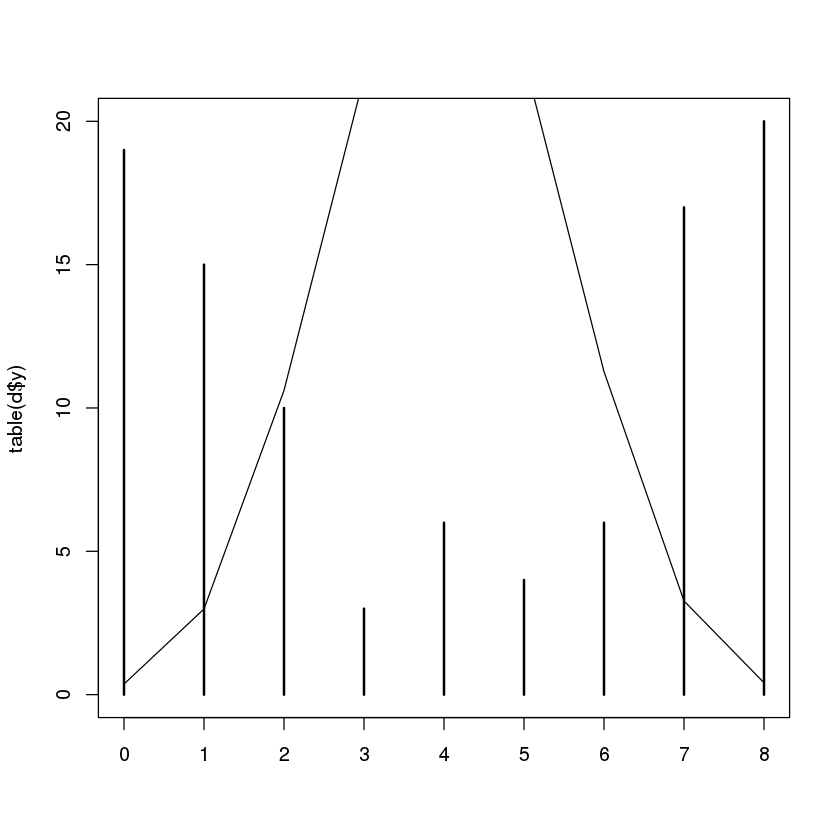

In [1]:
d <- read.csv('data7a.csv')
plot(table(d$y))
xx <- 0:8
lines(xx, dbinom(xx, 8, mean(d$y) / 8) * length(d$y))

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 102
   Total graph size: 610

Initializing model


Iterations = 1110:11100
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
beta  0.03417 0.3435 0.006272       0.011694
r[1] -3.82107 1.7849 0.032588       0.032594
r[2] -1.20674 0.9109 0.016630       0.019808
r[3]  1.99217 1.0962 0.020015       0.022812
s     3.04388 0.3669 0.006699       0.007803

2. Quantiles for each variable:

        2.5%     25%      50%     75%   97.5%
beta -0.6327 -0.1984  0.03509  0.2650  0.6885
r[1] -8.1341 -4.7955 -3.54212 -2.5754 -1.0635
r[2] -3.0283 -1.8094 -1.16345 -0.5873  0.5551
r[3]  0.1326  1.2588  1.90082  2.6180  4.4548
s     2.3921  2.7910  3.02003  3.2677  3.8541



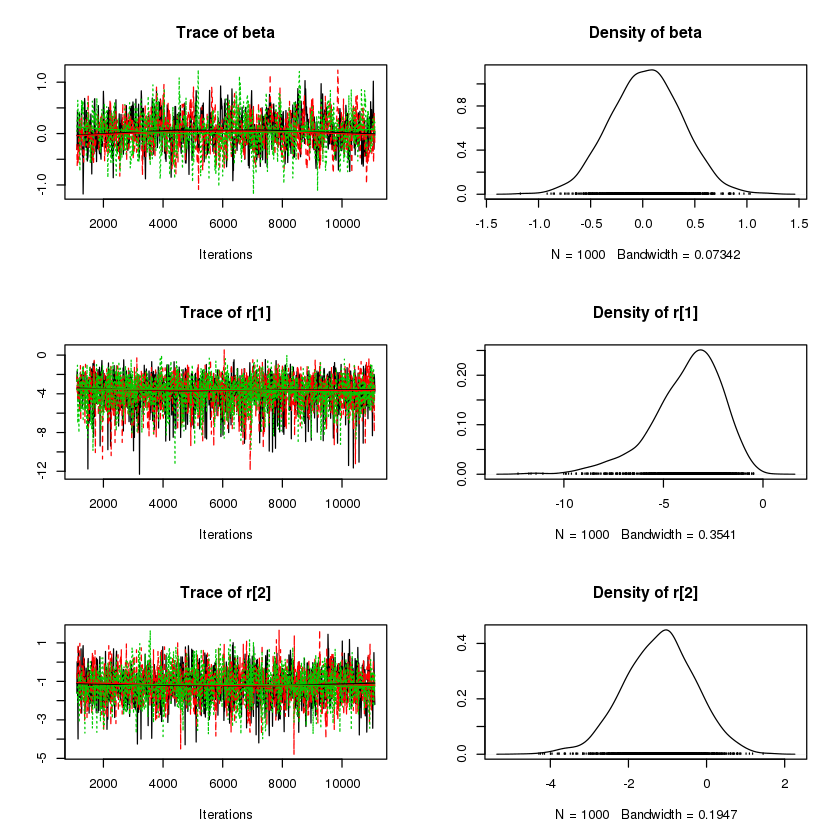

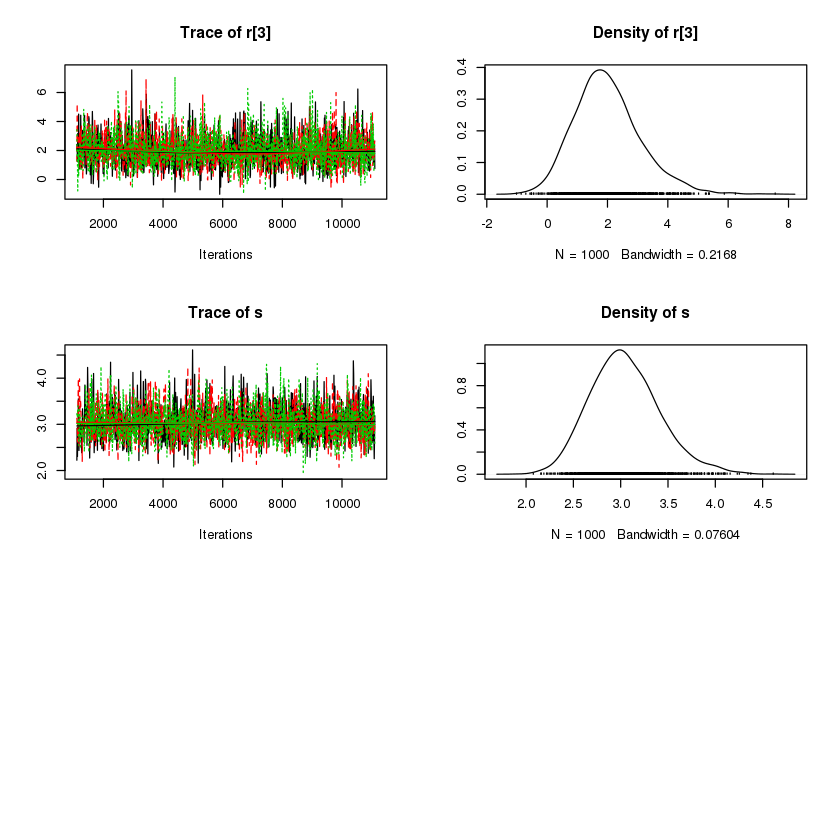

In [2]:
library(rjags)

list.data <- list(
    N = nrow(d),
    Y = d$y
)

inits <- list(
    beta = 0,
    r = rnorm(nrow(d), 0, 0.1),
    s = 1
)

m <- jags.model(
    file = "hierarchical.bug.txt",
    data = list.data,
    inits = inits,
    n.chains = 3
)

update(m, 100)

x <- coda.samples(
    m,
    c("beta", "s", "r[1]", "r[2]", "r[3]"),
    thin = 10,
    n.iter = 10000
)

print(summary(x))
plot(x)

# generating mp .............................. done


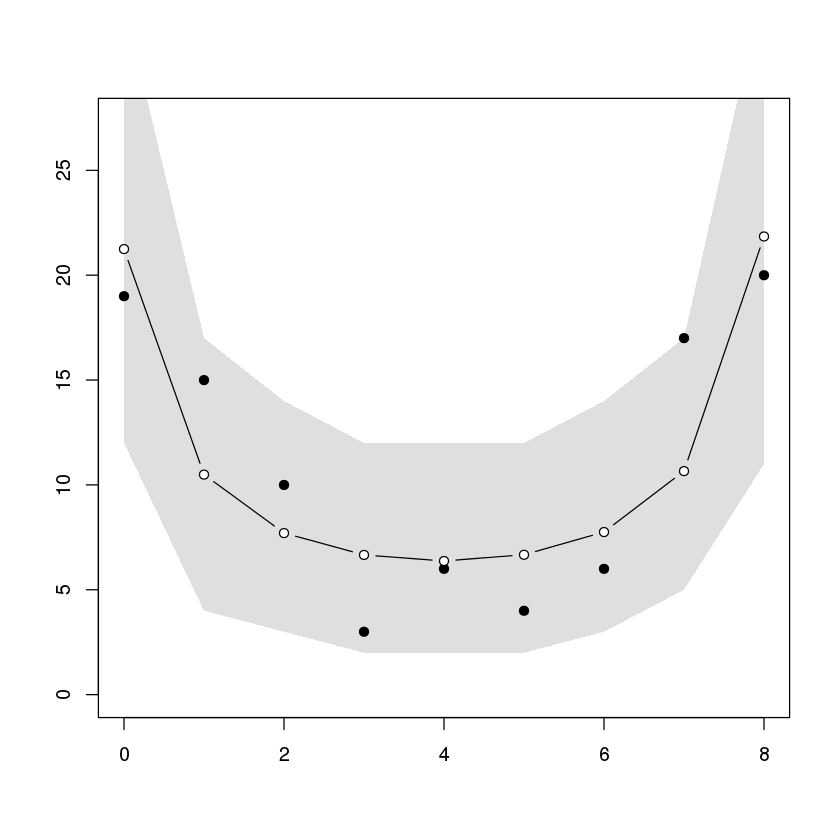

In [3]:
logistic <- function(z) 1 / (1 + exp(-z))
n <- nrow(d)
size <- 8
q <- sum(d$y) / (size * n)

f.gaussian.binom <- function(alpha, x, size, fixed, sd)
    dbinom(x, size, logistic(fixed + alpha)) * dnorm(alpha, 0, sd)

d.gaussian.binom <- function(v.x, size, fixed, sd) sapply(
    v.x, function(x) integrate(
        f = f.gaussian.binom,
        lower = -sd * 10,
        upper = sd * 10,
        # for f.gaussian.binom
        x = x,
        size = size,
        fixed = fixed,
        sd = sd
    )$value
)

plot.data <- function() plot(
    0:size, summary(as.factor(d$y)),
    ylim = range(c(0, dbinom(0:size, size, q) * n)),
    xlab = "",
    ylab = "",
    pch = 19
)

plot.polygon <- function(mm, p)
{
    pp <- 1 - p
    qp <- apply(mm, 1, quantile, probs = c(0.5 * pp, 1 - 0.5 * pp))
    polygon(
        c(0:size, size:0),
        c(qp[1,], rev(qp[2,])),
        border = NA,
        col = "#00000020"
    )
}

plot.lines <- function(mm)
{
    apply(
        mm, 2,
        function(x) lines(0:size, x, col = "#00000001", lwd = 2)
    )
}

beta <- as.matrix(x)[, "beta"]
sigma <- as.matrix(x)[, "s"]
if (!exists("my")) {
	cat("# generating mp ")
	mp <- sapply(
		1:length(as.matrix(x)[, 'beta']),
		function(i) {
			if (i %% 100 == 0) cat(".")
			d.gaussian.binom(
				0:size, size,
				fixed = beta[i],
				sd = sigma[i]
			)
		}
	)
	cat(" done\n")
	my <- apply(
		mp, 2, function(prob) summary(
			factor(
				sample(0:size, n, replace = TRUE, prob = prob),
				levels = 0:size
			)
		)
	)
}

plot.median <- function()
{
	lines(
		0:size, apply(mp * n, 1, median),
		type = "b",
		col = "black",
		bg = "white",
		pch = 21
	)
}

plot.data()
q.env <- apply(my, 1, quantile, probs = c(0.025, 0.975))
polygon(
	c(0:size, size:0),
	c(q.env[1,], rev(q.env[2,])), # 0.025 and 0.975
	border = FALSE,
	col = "#00000020"
)
plot.median()

In [4]:
d <- read.csv('d1.csv')
summary(d)

       id              pot     f            y        
 Min.   :  1.00   A      :10   C:50   Min.   : 0.00  
 1st Qu.: 25.75   B      :10   T:50   1st Qu.: 1.00  
 Median : 50.50   C      :10          Median : 3.00  
 Mean   : 50.50   D      :10          Mean   : 5.52  
 3rd Qu.: 75.25   E      :10          3rd Qu.: 7.00  
 Max.   :100.00   F      :10          Max.   :37.00  
                  (Other):40                         

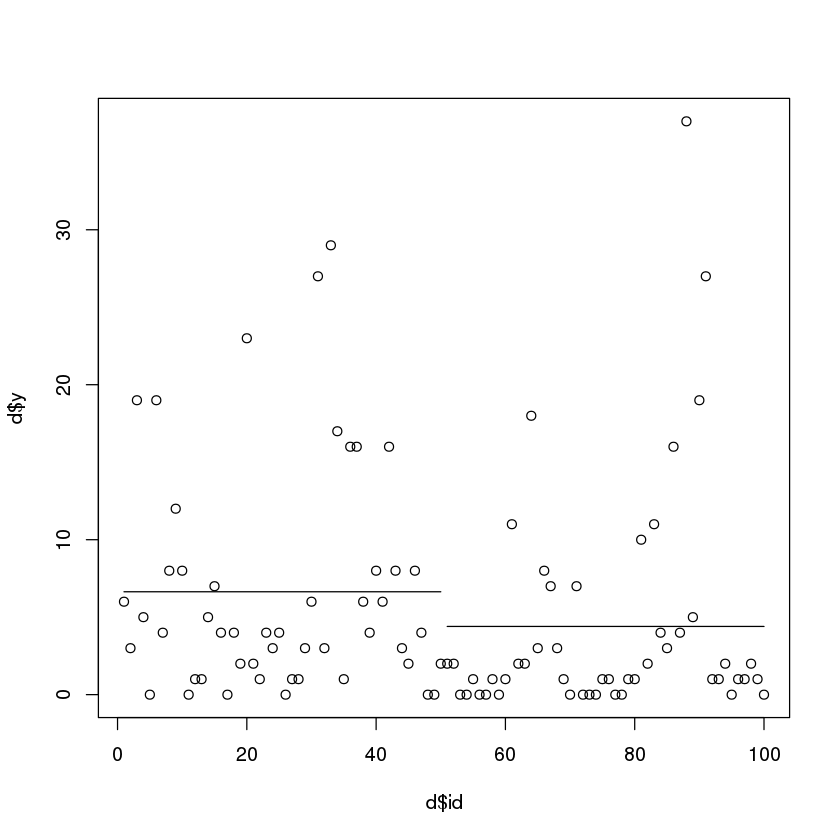

In [16]:
plot(d$id, d$y)
lines(x = c(1, 50), y = c(mean(d$y[d$f == 'C']), mean(d$y[d$f == 'C'])))
lines(x = c(51, 100), y = c(mean(d$y[d$f == 'T']), mean(d$y[d$f == 'T'])))

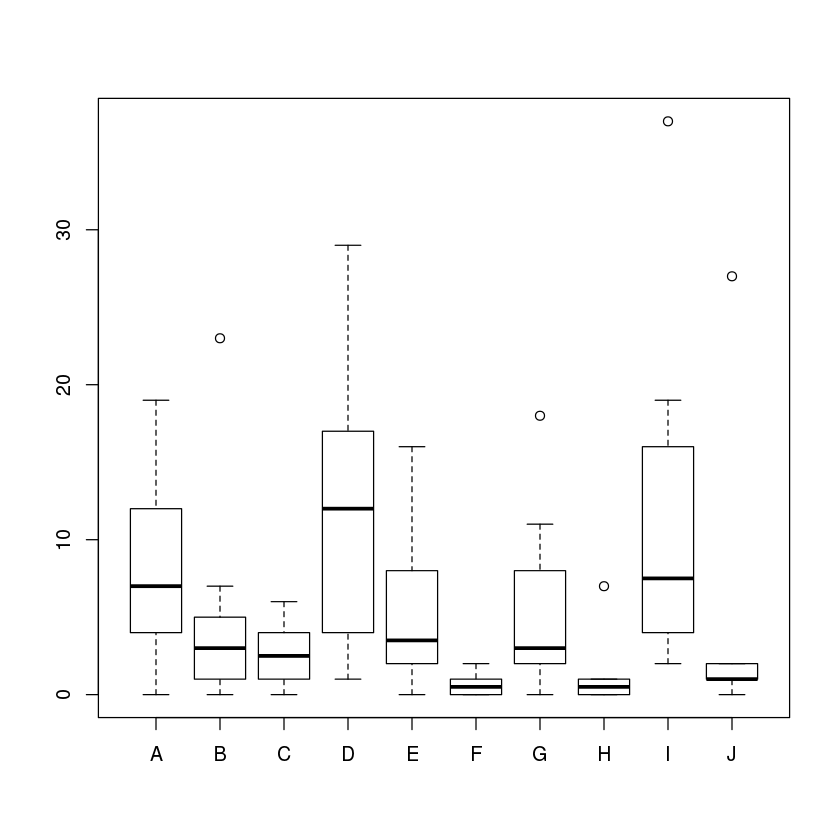

In [17]:
plot(d$pot, d$y)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 114
   Total graph size: 743

Initializing model


Iterations = 2050:52000
Thinning interval = 50 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
beta1  1.3326 0.5015 0.009156       0.025699
beta2 -0.8081 0.7322 0.013367       0.036394
s[1]   1.0192 0.1143 0.002087       0.002087
s[2]   1.0440 0.3887 0.007097       0.010260

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
beta1  0.3077  1.0327  1.3443  1.6577 2.2658
beta2 -2.2402 -1.2500 -0.7885 -0.3663 0.6741
s[1]   0.8204  0.9400  1.0122  1.0903 1.2580
s[2]   0.5201  0.7885  0.9692  1.2088 2.0072



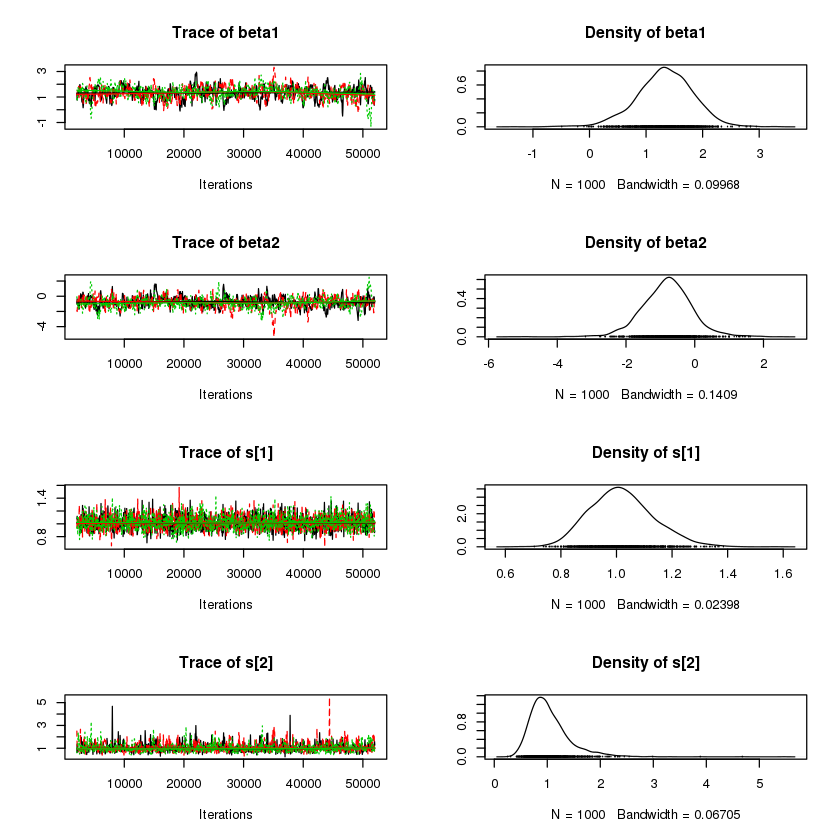

In [6]:
list.data <- list(
    N.sample = nrow(d),
    N.pot = length(levels(d$pot)),
    N.tau = 2,
    Y = d$y,
    F = as.numeric(d$f == "T"),
    Pot = as.numeric(d$pot)
)

inits <- list(
    beta1 = 0,
    beta2 = 0,
    r = rnorm(nrow(d), 0, 0.1),
    rp = rnorm(length(levels(d$pot)), 0, 0.1),
    s = c(1, 1)
)

m <- jags.model(
    file = "hierarchical2.bug.txt",
    data = list.data,
    inits = inits,
    n.chains = 3
)

update(m, 1000)

x <- coda.samples(
    m,
    c("beta1", "beta2", "s[1]", "s[2]"),
    thin = 50,
    n.iter = 50000
)

print(summary(x))
plot(x)